In [30]:
import requests
import pandas as pd
import numpy as np
import geopy.distance
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
url = "https://www.zabka.pl/app/uploads/locator-store-data.json"
response = requests.get(url)

df = pd.DataFrame.from_dict(response.json())
df = df[df['town'] == "Łódź"]
df = df[['lat', 'lon']]
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

In [32]:
df.head()

,lat,lon
112,51.774197,19.449903
167,51.732719,19.474108
168,51.728607,19.470244
188,51.766224,19.449934
216,51.763390,19.469598


In [99]:
distance_matrix = np.empty((len(df), len(df)))

for i1 in range(len(df)):
    for i2 in range(len(df)):
        point1 = (df.iloc[i1]['lat'], df.iloc[i1]['lon'])
        point2 = (df.iloc[i2]['lat'], df.iloc[i2]['lon'])
        
        d = geopy.distance.geodesic(point1, point2).km
        distance_matrix[i1, i2] = d
        distance_matrix[i2, i1] = d 

In [100]:
np.fill_diagonal(distance_matrix, np.inf)

In [101]:
closests_locs = distance_matrix.argmin(axis=1)
closests_distance = distance_matrix[np.arange(len(df)), closests_locs]

In [102]:
map_lodz = folium.Map(location=[51.7592, 19.4559], zoom_start=12)

for index, row in df.iterrows():
    lat = row['lat']
    long = row['lon']
    folium.CircleMarker(location=(lat, long), radius=3, weight=2, color='red', fill_color='red').add_to(map_lodz)
    
closest_dists_lim = []

for i, closest_index in enumerate(closests_locs):
    closest_lat = df.iloc[closest_index]['lat']
    closest_long = df.iloc[closest_index]['lon']
    curr_lat = df.iloc[i]['lat']
    curr_long = df.iloc[i]['lon']
    d = round(closests_distance[i], 2)
    folium.PolyLine([(curr_lat, curr_long), (closest_lat, closest_long)], color='black', popup=f"{round(closests_distance[i] * 1000 ,2)} m").add_to(map_lodz)
    closest_dists_lim.append(d)
    
map_lodz.save('zabkalodz.html')


In [103]:
print(closest_dists_lim[66])

110.0


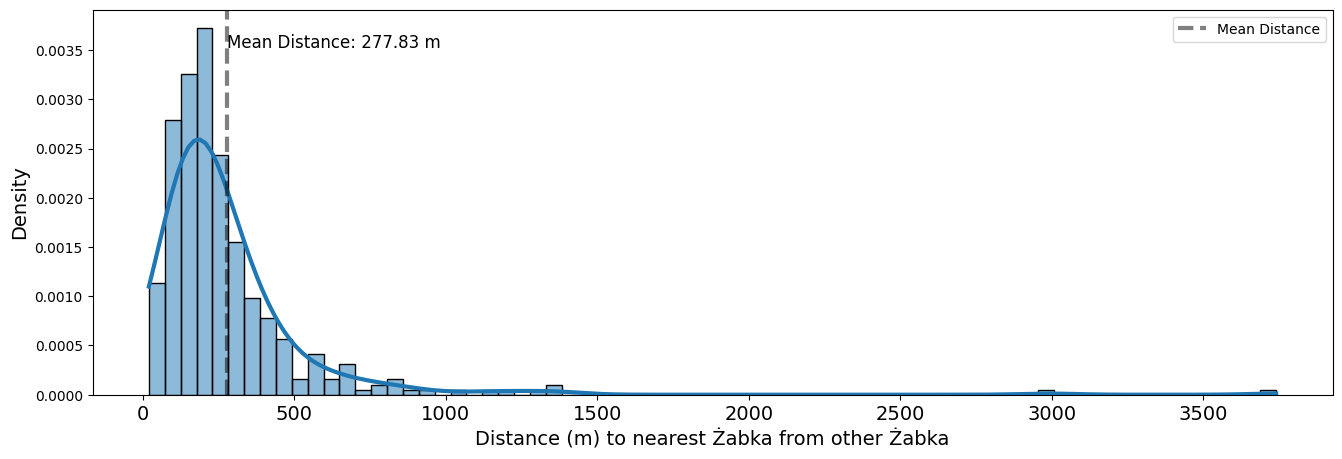

In [109]:
mean_distance = np.mean(closest_dists_lim)

plt.figure(figsize=(16, 5))
sns.histplot(closest_dists_lim, kde=True, line_kws={'linewidth': 3}, stat='density')
plt.xlabel('Distance (m) to nearest Żabka from other Żabka', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=14)
plt.axvline(np.mean(closest_dists_lim), color='black', linestyle='--', linewidth=3, alpha=0.5, label='Mean Distance')
plt.text(mean_distance + 0.05, plt.ylim()[1] * 0.9, f'Mean Distance: {mean_distance:.2f} m', fontsize=12, color='black')
plt.legend()
plt.show()
